In [1]:
import numpy as np
from sklearn.datasets import load_breast_cancer

data = load_breast_cancer()
X= data.data
y =data.target

In [2]:
from sklearn.model_selection import ShuffleSplit
ss = ShuffleSplit(n_splits=1,
                 train_size=0.8,
                 test_size=0.2,
                 random_state=0)
train_index, test_index = next(ss.split(X, y))

X_train, X_test = X[train_index], X[test_index]
y_train, y_test = y[train_index], y[test_index]

In [4]:
data.feature_names

array(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error',
       'fractal dimension error', 'worst radius', 'worst texture',
       'worst perimeter', 'worst area', 'worst smoothness',
       'worst compactness', 'worst concavity', 'worst concave points',
       'worst symmetry', 'worst fractal dimension'], dtype='<U23')

In [6]:
# 特徴を抽出するライブラリ
# SelectKBest => ベストな特徴を抽出する
# chi2 => カイ二乗検定を行う
from sklearn.feature_selection import SelectKBest, chi2

In [8]:
# 特徴を２０に絞っている
skb = SelectKBest(chi2, k=20)
skb.fit(X_train, y_train)

SelectKBest(k=20, score_func=<function chi2 at 0x000001782D469048>)

In [9]:
X_train_new = skb.transform(X_train)

In [11]:
# X_train_newのほうが、次元数が少なくなっている。つまり、有効である特徴がライブラリより得られている
X_train_new.shape, X_train.shape

((455, 20), (455, 30))

In [14]:
# 特徴のうち、抽出されたものがTrue、対象外のものがFalseで帰って来る
skb.get_support()

array([ True,  True,  True,  True, False,  True,  True,  True, False,
       False,  True, False,  True,  True, False,  True,  True, False,
       False, False,  True,  True,  True,  True, False,  True,  True,
        True,  True, False])

In [15]:
# 抽出された特徴名のみを表示
data.feature_names[skb.get_support()]

array(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean compactness', 'mean concavity', 'mean concave points',
       'radius error', 'perimeter error', 'area error',
       'compactness error', 'concavity error', 'worst radius',
       'worst texture', 'worst perimeter', 'worst area',
       'worst compactness', 'worst concavity', 'worst concave points',
       'worst symmetry'], dtype='<U23')

In [20]:
from sklearn.linear_model import LinearRegression
clf = LinearRegression()

from sklearn.model_selection import StratifiedKFold

k_range = np.arange(1, 31)
scores = []
std = []

for k in k_range:
    ss = StratifiedKFold(n_splits=10,
                                shuffle=True,
                                random_state=2)
    
    score = []
    for train_index, val_index in ss.split(X_train, y_train):
        
        X_train2, X_val = X[train_index], X[val_index]
        y_train2, y_val = y[train_index], y[val_index]
        
        # k個の特徴を選ぶ
        skb = SelectKBest(chi2, k=k)
        skb.fit(X_train2, y_train2)
        
        X_new_train2 = skb.transform(X_train2)
        X_new_val = skb.transform(X_val)
        
        # k個の特徴をベースに、識別器を学習
        clf.fit(X_new_train2, y_train2)
        score.append(clf.score(X_new_val, y_val))
        
    scores.append(np.array(score).mean())
    std.append(np.array(score).std())
        

In [21]:
scores

[0.5203712309311512,
 0.5151785202972241,
 0.5118480182596445,
 0.6402964651751346,
 0.6358958737389196,
 0.6568210707533864,
 0.6871656722265775,
 0.6892465975996209,
 0.7043709108084663,
 0.7018295551326105,
 0.7105631794962493,
 0.7148324141600699,
 0.7142459382736425,
 0.712019965138386,
 0.72477732606404,
 0.7316613511217945,
 0.7323105651761664,
 0.7333866793362389,
 0.7335489203392679,
 0.7320635025376211,
 0.7398174126105435,
 0.7409956939669581,
 0.741887306539379,
 0.7406272098105634,
 0.7395972664940504,
 0.73762990468109,
 0.7361626528773214,
 0.7328011728526057,
 0.7292919790184603,
 0.7292453139201692]

Text(0,0.5,'accuracy')

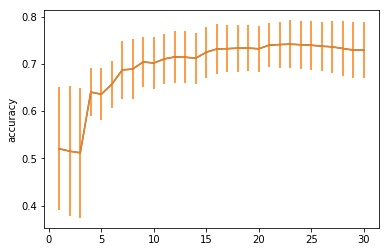

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(k_range, scores)
plt.errorbar(k_range, scores, yerr=std)
plt.ylabel("accuracy")

Text(0,0.5,'error rate')

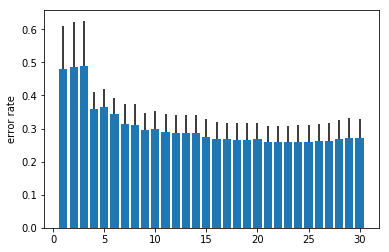

In [38]:
# 1からスコアを引いた数を表示。今回の場合は、０に近いほうが良いことになる
s_scores = np.ones(len(scores)) - scores
plt.bar(k_range, s_scores, yerr=[np.zeros(len(std)),  std])
plt.ylabel("error rate")

In [39]:
# 最も良い特徴を抽出
best_k = k_range[np.argmax(scores)]
best_k

23

In [44]:
# 上のBESTな特徴を用いて検定開始
skb = SelectKBest(chi2, k=best_k)

In [45]:
skb.fit(X_train, y_train)

SelectKBest(k=23, score_func=<function chi2 at 0x000001782D469048>)

In [46]:
X_train_best = skb.transform(X_train)
X_test_best = skb.transform(X_test)

In [47]:
# 上のBESTな特徴を用いて識別子を再学習
clf.fit(X_train_best, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [48]:
clf.score(X_test_best, y_test)

0.7347599052580366